# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [56]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 19
number_experiment = str(number_experiment)

# seed to generate same datasets
seed = 2

# training
epochs = 100000

# max elements by class
max_elements_per_class = 15000

# train with previous model
trainWithPreviousModel = False

# include delta errors
includeDeltaErrors = True

# band
# passband = [5]
passband = [0, 1, 2, 3, 4, 5]


# include ohter feautures
includeOtherFeatures = False

# num of features to add
# ṕvar by channel
otherFeaturesDim = 12

In [57]:
# cuda device
cuda_device = 0
cuda_device = "cuda:" + str(cuda_device)

# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

batch_training_size = 128

# early stopping 
threshold_early_stop = 1000

In [58]:
# training params
learning_rate = 1e-3

In [59]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "exp " + number_experiment + " + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed) + " + " + ("include delta errors" if includeDeltaErrors else "without delta errors") + " + max by class " + str(max_elements_per_class) + " + " + ("" if includeOtherFeatures else "not") + " other features"

print(comment)

exp 19 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 2 + include delta errors + max by class 15000 + not other features


# Import libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

if not trainingOnGuanaco:
    
    %matplotlib notebook
    %load_ext autoreload
    %autoreload 2
else:
    print("not load magics")
    
# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the path to save model while training

In [61]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.makedirs(folder_path)
        
    except OSError as error:
        print ("Creation of the directory %s failed" % folder_path)
        print(error)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

folder already exists


# Load data

In [54]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticData/"

## Loading dataset with pytorch tool

In [39]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = max_elements_per_class)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticData/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticData/plasticc_test_set_batch1.csv


In [40]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# plot light curve

In [10]:
# lc_data, label, lc_id = torch_dataset_lazy.__getitem__(1300)

# # 11 was good

# fig, ax = plt.subplots(figsize= (8,6), tight_layout=True)
# for band, band_name in enumerate('ugrizY'):
#     mask = lc_data[band, 3, :] == 1
#     mjd, flux, flux_err = lc_data[band, :3, mask]
#     ax.errorbar(mjd, flux, flux_err, fmt='.', label=band_name)
# ax.legend()
# ax.set_ylabel('Flux', fontsize = 20)
# ax.set_xlabel('Modified Julian Data', fontsize = 20)
# ax.set_title(f'PLAsTiCC ID: {lc_id} Label: {label}', fontsize = 20)

In [11]:
# fig.savefig("lightCurve.pdf", bbox_inches='tight')

# Spliting data (train/test)

In [12]:
# splitting the data

# get light curves ids, targets
ids, targets, lightCurvesIds = getLightCurvesIds(torch_dataset_lazy)

# test array shapes
# assert len(targets) == torch_dataset_lazy.__len__()
# print(ids, len(ids), targets, len(targets))
# get light curves targets
print("# light curves ids: " + str(len(ids)))

# split training
trainIdx, tmpIdx = train_test_split(
    ids,
    test_size = 0.2,
    shuffle = True,
    stratify = targets,
    random_state = seed
)

# float to int
tmpIdx = tmpIdx.astype(int)

# split val, test
valIdx, testIdx = train_test_split(
    tmpIdx,
#     targets,
    test_size = 0.5,
    shuffle = True,
    stratify = targets[tmpIdx],
    random_state = seed
)

# float to int
trainIdx = trainIdx.astype(int)
valIdx = valIdx.astype(int)
testIdx = testIdx.astype(int)

# light curves ids: 3276


In [13]:
# saving ids
saveLightCurvesIdsBeforeBalancing(trainIdx, valIdx, testIdx, folder_path, lightCurvesIds, targets)

light curves ids saved on a file


In [14]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_before_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output)

<IPython.core.display.Javascript object>


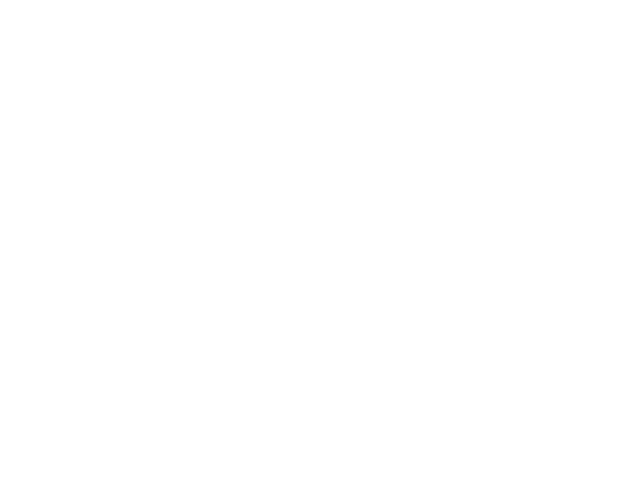

(array([ 16.,  93.,   0.,   0.,   0.,   4., 104.,   0.,   0., 111.]),
 array([ 6. , 14.6, 23.2, 31.8, 40.4, 49. , 57.6, 66.2, 74.8, 83.4, 92. ]),
 <BarContainer object of 10 artists>)

In [15]:
# # analize classes distributino
fig, ax = plt.subplots(3, 1)

ax[0].hist(targets[trainIdx])
ax[1].hist(targets[valIdx])
ax[2].hist(targets[testIdx])

In [16]:
# # Spliting the data

# # print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

# totalSize = totalSize
# # print(totalSize)

# selecting train splitting
# train_size = int(0.8 * totalSize)
train_size = trainIdx.shape[0]
#print(train_size)

# # getting test splitting
# validation_size = math.floor((totalSize - train_size)/3)
validation_size = valIdx.shape[0]
# #print(validation_size)

# # getting test splitting
# test_size = totalSize - train_size - validation_size
test_size = testIdx.shape[0]
# #print(test_size)

# # spliting the torch dataset
# trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
#     torch_dataset_lazy, 
#     [train_size, validation_size, test_size],
    
#     # set seed
#     generator = torch.Generator().manual_seed(seed)
# )

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
totTmp = train_size+ validation_size + test_size
print("sum: ", totTmp)
assert torch_dataset_lazy.__len__() == totTmp, "dataset partition should be the same"

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

In [17]:
print("initila distribution")
# initialClassesDistribution = countClasses(trainDataset, only_these_labels)
initialClassesDistribution = np.unique(targets, return_counts=True)[1]

print(initialClassesDistribution)

# fig, ax = plt.subplots()
# ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

initila distribution
[ 157  927   36 1042  733  381]


In [18]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
        seed = seed
#         indices = [0, 1, 2]
    ),
#     sampler = torch.utils.data.SubsetRandomSampler(
#         trainIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
    batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = valIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         valIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
#     sampler=ImbalancedDatasetSampler(
#         torch_dataset_lazy, 
#         indices = valIdx,
#         seed = seed
# #         indices = [0, 1, 2]
#     ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = testIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         testIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
)

In [19]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

print(balancedClassesDistribution)
# fig, ax = plt.subplots()
# ax.bar(x = np.ar# return 0# return 0ange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

balanced distribution
[444. 420. 439. 474. 400. 443.]


In [20]:
# save ids of dataset to use (train, test and validation)
saveLightCurvesIdsAfterBalancing(trainLoader, train_size, testLoader, test_size, validationLoader, validation_size, path = folder_path)

light curves ids saved on a file


In [21]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_after_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output["validation"])

# Get other features

In [22]:
if includeOtherFeatures:
    
    # save features
    trainOtherFeaturesArray = np.zeros(shape = (train_size, otherFeaturesDim))
    validOtherFeaturesArray = np.zeros(shape = (validation_size, otherFeaturesDim))

    print("starting to get the other features")

    trainLastIndex = 0
    validLastIndex = 0
    
    for trainData_ in trainLoader:
        
        # get other features by batch
        # [batch size, features]
        trainOtherFeatures = getOtherFeatures(trainData_[0]).to(device = cuda_device)

        # indexation
        trainLastIndex_ = trainLastIndex + trainData_[0].shape[0]
        
        # save features in array indexing them
        trainOtherFeaturesArray[trainLastIndex : trainLastIndex_] = trainOtherFeatures.cpu().numpy()
            
        # update indexs
        trainLastIndex = trainLastIndex_
    
    # test size
    assert trainLastIndex == train_size
    
    for validData_ in validationLoader:
        
        # get other features by batch
        # [batch size, features]
        validOtherFeatures = getOtherFeatures(validData_[0]).to(device = cuda_device)

        # indexation
        validLastIndex_ = validLastIndex + validData_[0].shape[0]
        
        # save features in array indexing them
        validOtherFeaturesArray[validLastIndex : validLastIndex_] = validOtherFeatures.cpu().numpy()
            
        # update indexs
        validLastIndex = validLastIndex_
    
    # test size
    assert validLastIndex == validation_size
    
    print("finish to get other features")
    
    print("normalize features")
    # normalize features
    trainNormalizedFeatures = torch.from_numpy(normalizeOtherFeatures(trainOtherFeaturesArray)).type(torch.FloatTensor)
    validNormalizedFeatures = torch.from_numpy(normalizeOtherFeatures(validOtherFeaturesArray)).type(torch.FloatTensor)
    
    # check nan values
    print(f"nan values train: {np.any(torch.isnan(trainNormalizedFeatures).cpu().numpy())}")
    print(f"nan values valid: {np.any(torch.isnan(validNormalizedFeatures).cpu().numpy())}")

In [23]:
# # test shape
# assert (trainNormalizedFeatures.shape == trainOtherFeaturesArray.shape)
# assert (validNormalizedFeatures.shape == validOtherFeaturesArray.shape)
# print(trainNormalizedFeatures.shape)
# print(validNormalizedFeatures.shape)

# # test man values on normalized
# print(torch.mean(torch.from_numpy(trainOtherFeaturesArray), dim = 0))
# print(torch.mean(trainNormalizedFeatures, dim = 0))

# print(torch.mean(torch.from_numpy(validOtherFeaturesArray), dim = 0))
# print(torch.mean(validNormalizedFeatures, dim = 0))

# # test max values on normalized
# print(torch.max(torch.from_numpy(trainOtherFeaturesArray), dim = 0))
# print(torch.max(trainNormalizedFeatures, dim = 0))

# print(torch.max(torch.from_numpy(validOtherFeaturesArray), dim = 0))
# print(torch.max(validNormalizedFeatures, dim = 0))

## Create experiment parameters file

In [24]:
# store varibales on file
if trainingOnGuanaco or trainWithJustPython:
    text_file = open("../" + expPath + "/experimentParameters.txt" , "w")
    text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
    text_file.write(text)
    text_file.close()
    print("experiment parameters file created")

## Defining parameters to Autoencoder

In [25]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)

if trainWithPreviousModel:
    
    # loadgin model
    model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)
    
    print("loading saved model")
    
else:
    
    # defining model
    model = EncoderClassifier(
        latent_dim = latentDim, 
        hidden_dim = hiddenDim, 
        input_dim = inputDim, 
        num_classes = num_classes, 
        passband = passband, 
        includeDeltaErrors = includeDeltaErrors,
        includeOtherFeatures = includeOtherFeatures,
        otherFeaturesDim = otherFeaturesDim,
    )

    # mdel to GPU
    model = model.to(device = cuda_device)
    
    print("creating model with default parameters")

creating model with default parameters


In [26]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=512, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


### Training

<IPython.core.display.Javascript object>


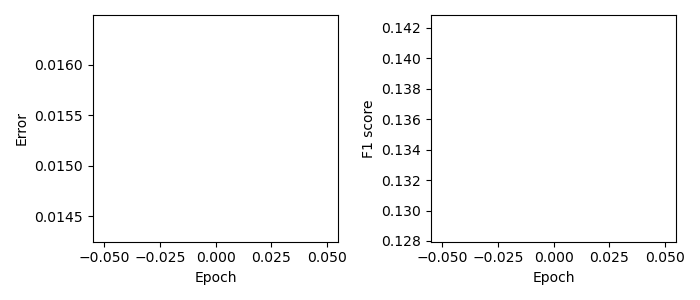

starting the training
epoch:    0 / 2
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    1 / 2
New min test loss. Saving model
saving losses
saving f1 scores
training has finished


In [27]:
from sklearn.metrics import f1_score

# optimizeraa
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
count_early_stop = 0


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    
    
    
    epoch_train_loss = 0
    
    # this is for getting the other features
    trainLastIndex = 0
    
    for data_ in trainLoader:
        
        # get raw data and labels
        labels = data_[1].to(device = cuda_device)
        
        # optimzer to zero
        optimizer.zero_grad()
            
        # this returns deltas
        data = generateDeltas(data_[0], passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
            
        # add other features
        # [batch size, features dim]
        if includeOtherFeatures:
            
            # index to include batch data
            trainLastIndex_ = trainLastIndex + data_[0].shape[0]

            # get only the normalized data from the batch (by indexation)
            otherFeatures = trainNormalizedFeatures[trainLastIndex : trainLastIndex_, :].to(device = cuda_device)
            
            # update index 
            trainLastIndex = trainLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
            
            
        else:
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors)

        # validate nana values on output model
        if np.any(torch.isnan(outputs).cpu().numpy()):
                
                print(f"outpues with nan values in epoch {nepoch}")
                

        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
            
        # validate nan values on loss
        if np.any(torch.isnan(loss).cpu().numpy()):
                
                print(f"loss with nan values in epoch {nepoch}")
                
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        
    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    
    
    
    
    ##### Validation ########
    
    
    
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # this is to get other features
    validLastIndex = 0
    
    # minibatches
    for data_ in validationLoader:
        
        labels = data_[1].to(device = cuda_device)
            
        # get deltas
        data = generateDeltas(data_[0], passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
    
        
        # inlcude other features
        if includeOtherFeatures:
            
            validLastIndex_ = validLastIndex + data_[0].shape[0]

            otherFeatures = validNormalizedFeatures[validLastIndex : validLastIndex_, :].to(device = cuda_device)
        
            validLastIndex = validLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
                
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
        
        else:
        
            # get model output
            outputs = model.forward(data, includeDeltaErrors)
        
        if np.any(torch.isnan(outputs).cpu().numpy()):
                
                print(f"outputs with nan values in epoch {nepoch}")
                
        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
        
        #  store minibatch loss value
        epoch_test_loss += loss.item()

        # f1 score
        f1Score += f1_score(
            mapLabels(labels, only_these_labels).cpu().numpy(), 
            torch.argmax(outputs, 1).cpu().numpy(), 
            average = "weighted"
        )
        
        
        # batch counter
        batchCounter += 1
    
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    
    
    
    
    
    
    # plot values
    
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    
    
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar, expPath)
                
   


    #### save losses ####
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("../" + expPath + "/training_losses.csv", losses, delimiter=",")
    

    
    
    ### save f1 scores ####
    print("saving f1 scores")
    np.savetxt("../" + expPath + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
    
    #### Early stopping #####
    # If minimum global validation error does not decrease in X epochs, so stop training
    
    
    
    # if new test loss is greater than the min valid error
    if test_loss[nepoch] > minTestLossGlobalSoFar:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
        
    # if it is smaller
    else: 
        count_early_stop = 0
    
    # analyze early stopping
    if count_early_stop >= threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("../" + expPath + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n".format(nepoch, count_early_stop)
        text_file.write(metricsText)
        text_file.close()
        break
        
    
    
# final message
print("training has finished")

In [29]:
# get metrics on trainig dataset

if not includeOtherFeatures:
    trainNormalizedFeatures = None
    validNormalizedFeatures = None
    
getConfusionAndClassificationReport(
    trainLoader, 
    nameLabel = "Train", 
    passband = passband, 
    model = model, 
    staticLabels = only_these_labels, 
    number_experiment = number_experiment, 
    expPath = expPath, 
    includeDeltaErrors = includeDeltaErrors, 
    includeOtherFeatures = includeOtherFeatures,
    normalizedFeatures = trainNormalizedFeatures,
)


# get metrics on validation dataset
getConfusionAndClassificationReport(
    validationLoader, 
    nameLabel = "Validation", 
    passband = passband, 
    model = model, 
    staticLabels = only_these_labels, 
    number_experiment = number_experiment, 
    expPath = expPath, 
    includeDeltaErrors = includeDeltaErrors, 
    includeOtherFeatures = includeOtherFeatures,
    normalizedFeatures = validNormalizedFeatures,
)

saving confusion matrix scores with normalize: true
saving confusion matrix scores with normalize: pred
saving confusion matrix scores with normalize: all
saving clasification report
saving confusion matrix scores with normalize: true
saving confusion matrix scores with normalize: pred
saving confusion matrix scores with normalize: all
saving clasification report


### Stop execution if it's on cluster

In [ ]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

In [ ]:
sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

# Analyzing training

In [8]:
!cat ../experiments/18/seed0/maxClass15k/experimentParameters.txt

N° experiment: 18
 General comment: exp 18 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 0 + include delta errors + max by class 15000 + not other features
 Classes: [16, 92, 53, 88, 65, 6]
 train_size: 52360
 validation_size: 6545
 test_size: 6546
 total dataset size: 65451
 Epochs: 100000
 Latent dimension: 100
 Hidden dimension: 100
 Input dimension: 72
 Passband: [0, 1, 2, 3, 4, 5]
 Learning rate: 0.0001
 Batch training size: 128
 initial train classes distribution: [ 1454 15924  1483 15981 15370 15239]
balanced train class distribution: [8776. 8703. 8609. 8751. 8730. 8791.]

/home/leo/Desktop/thesis/work/thesis/experiments/19/seed2/maxClass15k


<IPython.core.display.Javascript object>


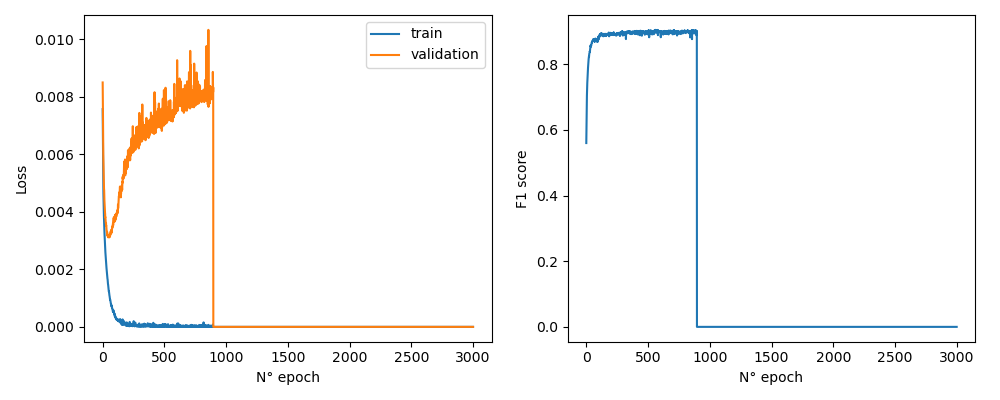

In [62]:
# load losses array
# losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/seed" + str(seed) + "/training_losses.csv")
losses = pd.read_csv(folder_path + "/training_losses.csv")
# f1 scores
# f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

print(folder_path)

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

maxPlot = 3000

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:maxPlot, 0], label = "train")
ax[0].plot(losses.iloc[:maxPlot, 1], label = "validation")
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores.iloc[:maxPlot])

# best model
# values copied from the txt file
# bestModelEpoch = 785
# bestModelError = 0.00434128265165168
# ax[0].scatter(bestModelEpoch, bestModelError, c = "r", linewidths = 10)
# ax[1].scatter(bestModelEpoch, f1Scores.iloc[bestModelEpoch], c = "r", linewidths = 10)

In [11]:
!cat ../experiments/19/seed2/maxClass15k/bestScoresModelTraining.txt

Epoch: 54
 Reconstruction test error: 0.0031110598760492663

In [14]:
# confusion matrix
import pandas as pd
import seaborn as sn

# select normalization
# norm = {‘true’, ‘pred’, ‘all’}
normalization = "true"

# get confusion matrix
cmTrain = pd.read_csv(folder_path  + '/confusionMatrixTrain_norm_' + normalization + '.csv', header = None) 
cmValidation = pd.read_csv(folder_path + '/confusionMatrixValidation_norm_' + normalization + '.csv', header = None) 

print(folder_path)
print("Training")
print("Normalization: " + normalization)
sn.heatmap(cmTrain, annot=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/leo/Desktop/thesis/work/thesis/experiments/19/seed0/maxClass15k/confusionMatrixTrain_norm_true.csv'

In [32]:
print("Validation")
sn.heatmap(cmValidation, annot = True)

Validation


<AxesSubplot:>

In [33]:
# classification report
!cat ../experiments/99/seed0/maxClass15k/clasificationReportTrain.txt

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       444
         1.0       0.25      0.00      0.01       420
         2.0       0.00      0.00      0.00       439
         3.0       0.18      1.00      0.31       474
         4.0       0.00      0.00      0.00       400
         5.0       0.00      0.00      0.00       443

    accuracy                           0.18      2620
   macro avg       0.07      0.17      0.05      2620
weighted avg       0.07      0.18      0.06      2620


In [34]:
# classification report
!cat ../experiments/99/seed0/maxClass15k/clasificationReportValidation.txt

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        93
         1.0       0.50      0.03      0.05        38
         2.0       0.00      0.00      0.00         3
         3.0       0.22      0.99      0.37        74
         4.0       0.00      0.00      0.00       105
         5.0       0.00      0.00      0.00        15

    accuracy                           0.23       328
   macro avg       0.12      0.17      0.07       328
weighted avg       0.11      0.23      0.09       328
